In [8]:

import pandas as pd
import re,os,sys
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/missy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/missy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/missy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
os.chdir('..')

# Import NewsDataLoader and configuration
from src.loader import NewsDataLoader
from src.config import cfg

# Import utility functions
import src.utils as utils

data_loader = NewsDataLoader(cfg.path)
data_df = data_loader.get_news_data()
traffic_data_df = data_loader.get_traffic_data()
domains_df = data_loader.get_domain_location_data()

Namespace(output='news_output.csv', path='data', news='rating.csv', traffic='trafiic.csv', domain='domains_location.csv')
Output File: news_output.csv
Path: data
News Data: rating.csv
Traffic Data: trafiic.csv
Domain Location Data: domains_location.csv


In [3]:

# Drop unnecessary columns
if 'source_id' in data_df.columns:
    data_df.drop(columns=['source_id'], inplace=True)

if 'url_to_image' in data_df.columns:
    data_df.drop(columns=['url_to_image'], inplace=True)

# Drop rows with missing values
data_df = data_df.dropna(axis=0)
domain_locations_df = domains_df.dropna(axis=0)

# rating_df['domain'] = rating_df['url'].apply(get_domain)

merge_df=pd.merge(data_df, domain_locations_df ,left_on='source_name', right_on ='SourceCommonName' ,how ='left')
merge_df=pd.merge(merge_df, traffic_data_df , left_on ='source_name' ,right_on='Domain' ,how ='left')

Number of events: 10
News sites reporting events earliest:
 source_name
Android Central                 2023-10-01 20:00:46.000000
Al Jazeera English              2023-10-01 20:22:17.000000
Deadline                        2023-10-01 23:35:34.000000
BBC News                        2023-10-02 00:04:05.000000
Business Insider                2023-10-02 00:10:25.000000
RT                              2023-10-02 01:32:33.000000
Forbes                          2023-10-02 02:03:15.000000
The Indian Express              2023-10-02 02:04:23.000000
International Business Times    2023-10-02 02:45:30.000000
Time                            2023-10-02 05:00:00.000000
GlobeNewswire                   2023-10-02 05:30:00.000000
The Times of India              2023-10-02 06:42:03.000000
Phys.Org                        2023-10-02 07:30:39.000000
Globalsecurity.org              2023-10-02 08:07:51.000000
Marketscreener.com              2023-10-02 08:16:05.000000
NPR                             2023-10-02 

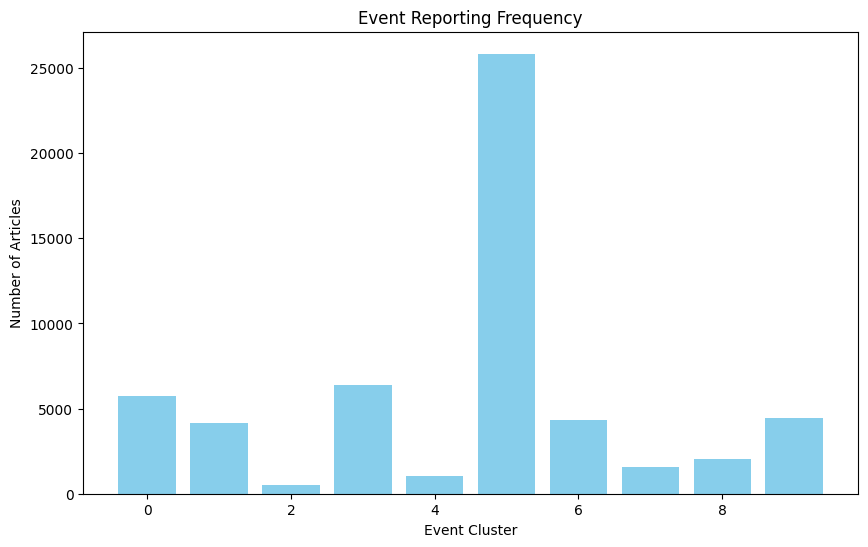

In [4]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    tokens = word_tokenize(text)
    # Remove stop words and apply stemming
    filtered_tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    # Join the filtered tokens back into text
    preprocessed_text = ' '.join(filtered_tokens)
    return preprocessed_text

merge_df['preprocessed_content'] = merge_df['content'].apply(preprocess_text)

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(merge_df['preprocessed_content'])

#  Clustering
num_clusters = 10  # Choose an appropriate number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)


merge_df['cluster'] = kmeans.labels_

# Count the number of events covered in the data
num_events = merge_df['cluster'].nunique()
print("Number of events:", num_events)

# Determine which news sites report events the earliest
earliest_reporting = merge_df.groupby('source_name')['published_at'].min()
earliest_reporting = earliest_reporting.sort_values()
print("News sites reporting events earliest:\n", earliest_reporting)

event_counts = merge_df['cluster'].value_counts()
print("Event reporting frequency:\n", event_counts)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(event_counts.index, event_counts.values, color='skyblue')
plt.xlabel('Event Cluster')
plt.ylabel('Number of Articles')
plt.title('Event Reporting Frequency')
plt.show()

In [20]:
print(data_df.columns)

# # Drop rows with missing values
data_df.dropna(axis=0, inplace=True)
domain_locations_df.dropna(axis=0, inplace=True)

# # Merge dataframes
merge_df = pd.merge(data_df, domain_locations_df, left_on='source_name', right_on='SourceCommonName', how='left')
merge_df = pd.merge(merge_df, traffic_data_df, left_on='source_name', right_on='Domain', how='left')




Index(['article_id', 'source_name', 'author', 'title', 'description',
       'published_at', 'content', 'category', 'article', 'title_sentiment'],
      dtype='object')


/var/folders/14/f3j86z751wb6b5yyjr_10z0c0000gn/T/ipykernel_76780/4062445611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  domain_locations_df.dropna(axis=0, inplace=True)


In [21]:

# Preprocess text data
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalnum()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

merge_df['processed_content'] = merge_df['content'].apply(preprocess_text)

# Sample the data
sample_size = 10  # Adjust the sample size as needed
merge_df = merge_df.sample(n=sample_size, random_state=42)

In [22]:
# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(merge_df['processed_content'])

X_sparse = csr_matrix(X)
cosine_sim_matrix = cosine_similarity(X_sparse)
similarity_threshold = 0.5

# Fit LDA model
num_topics = 10  # Adjust the number of topics as needed
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# Assign topics to articles
merge_df['topic'] = lda_model.transform(X).argmax(axis=1)

# Apply event detection to each article in the sampled subset
related_articles_list = []
for article_index in range(len(merge_df)):
    related_articles = set()
    for i, similarity_score in enumerate(cosine_sim_matrix[article_index]):
        if similarity_score > similarity_threshold:
            related_articles.add(i)
    related_articles_list.append(related_articles)

merge_df['related_articles'] = related_articles_list

# Explore the detected events
for event_id, event_articles in enumerate(merge_df['related_articles']):
    print(f"Event {event_id}:")
    for article_index in event_articles:
        if article_index < len(merge_df):  # Check if the index is within bounds
            article = merge_df.iloc[article_index][['title', 'content']]
            print(article)
    print()

Event 0:
title      Maui Land & Pineapple (NYSE:MLP) Upgraded to “...
content    StockNews.com upgraded shares of Maui Land &am...
Name: 43500, dtype: object
title      Russell Investments Group Ltd. Has $108.23 Mil...
content    Russell Investments Group Ltd. reduced its sta...
Name: 40349, dtype: object

Event 1:
title      Art & Craft Tools Market Size to Hit USD 5.44 ...
content    Pune, India, Nov. 22, 2023 (GLOBE NEWSWIRE) --...
Name: 49392, dtype: object

Event 2:

Event 3:
title      linkedin's 'open to work' tag is the 'biggest ...
content    LinkedIn lets users put an "Open to Work" badg...
Name: 3120, dtype: object
title      Sharon Stone Paid Leonardo DiCaprio’s, Russell...
content    Leonardo DiCaprio still remembers Sharon Stone...
Name: 41226, dtype: object

Event 4:
title      israel gaza: joe biden calls for 'pause' in co...
content    US President Joe Biden has called for a "pause...
Name: 3181, dtype: object

Event 5:
title              Stock Market Exhibiting ‘Bull 